# IMPORT LIBS

In [22]:
import sys
sys.path.insert(1, "/home/lucas/AffectiveComputing")

from keras.layers import Embedding, LSTM, Dropout, Dense, BatchNormalization, Bidirectional
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from libs.pre_processing import PreProcessing 
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer
from warnings import filterwarnings
from keras.models import Sequential
from random import choice
import tensorflow as tf
from os import environ
import pandas as pd
import numpy as np



model_name = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

pp = PreProcessing()
filterwarnings("ignore")

# LOAD DATA

In [42]:
path = '/home/lucas/AffectiveComputing/data_source/ceweb/test.csv'
data = pd.read_csv(path, delimiter='\t')

In [3]:
emotion_name = {0: 'admiração', 1: 'diversão', 2: 'raiva', 3: 'aborrecimento',
                4: 'provação', 5: 'confusão', 6: 'curiosidade', 7: 'desejo',
                8: 'decepção', 9: 'desaprovação', 10: 'nojo', 11: 'vergonha', 
                12: 'entusiasmo', 13: 'medo', 14: 'gratidão', 15: 'luto', 
                16: 'alegria', 17: 'amor', 18: 'nervosismo', 19: 'otimismo',
                20: 'orgulho', 21: 'alívio', 22: 'remorso', 23: 'tristeza',  
                24: 'surpresa', 25: 'saudade', 26: 'inveja', 27: 'compaixão'}

In [4]:
def _preprocessing_train(dataframe, column):
    dataframe = pp.dropnan_and_lowercase(dataframe, column)
    dataframe = pp.change_abbreviations_dataframe(dataframe, column)
    dataframe = pp.drop_size(dataframe, column, 3)
    dataframe = pp.set_category(dataframe, 'categoria')
    dataframe = pp.apply_regex_dataframe(dataframe, column)
    dataframe = pp.shuffled_dataframe(dataframe)
    dataframe = pp.remove_stopwords_dataframe(dataframe, column)
    return dataframe

In [5]:
data = _preprocessing_train(data, "tweet")
texts = data.tweet
labels = np.array(data.categoria.tolist())
texts_train, texts_val, labels_train, labels_val = train_test_split(texts, labels, test_size=0.2, random_state=42)

texts_train = texts_train.tolist()

inputs_train = tokenizer(texts_train, max_length=64, padding=True, truncation=True, return_tensors='tf')

labels_train = tf.convert_to_tensor(labels_train, dtype=tf.int64)
labels_val = tf.convert_to_tensor(labels_val, dtype=tf.int64)

inputs_train_ids = inputs_train['input_ids']
inputs_train_ids = np.array(inputs_train_ids).astype(int)

labels_train_np = labels_train.numpy()
labels_val_np = labels_val.numpy()

texts_val = texts_val.tolist()
inputs_val = tokenizer(texts_val, max_length=64, padding=True, truncation=True, return_tensors='tf')
inputs_val_ids = np.array(inputs_val['input_ids']).astype(int)

encoder = OneHotEncoder(sparse=False)
labels_train_encoded = encoder.fit_transform(tf.reshape(labels_train, (-1, 1)).numpy())
labels_val_encoded = encoder.transform(tf.reshape(labels_val, (-1, 1)).numpy())

2024-01-01 10:55:00.848042: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-01 10:55:00.900678: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## EMBEDDING LSTM

In [48]:
## find best parameter
np.random.seed(42)
tf.random.set_seed(42)

units_values = [64, 128, 256]
optimizer_values = ['adam', 'rmsprop']
batch_size_values = [32, 64, 128]
activation_values = ['tanh', 'relu']
kernel_initializer_values = ['glorot_uniform', 'orthogonal']

best_score = float('-inf')  
list_best = []
def train_model(X_train, y_train, X_val, y_val):
    units = choice(units_values)
    activation = choice(activation_values)
    kernel_initializer = choice(kernel_initializer_values)
    batch_size = choice(batch_size_values)
    optimizer = choice(optimizer_values)

    model = Sequential([
        Embedding(input_dim=len(tokenizer.get_vocab()), output_dim=64, input_length=64),
        Bidirectional(LSTM(units, activation=activation, kernel_initializer=kernel_initializer, return_sequences=True)),
        BatchNormalization(),
        Bidirectional(LSTM(units, activation=activation, kernel_initializer=kernel_initializer)),
        BatchNormalization(),
        Dropout(0.2, seed=42),
        Dense(28, activation='softmax')
    ])
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    print(f"Training model with units={units}, optimizer={optimizer}, batch_size={batch_size}, activation={activation}, kernel_initializer={kernel_initializer}")
    
    model.fit(X_train, y_train, epochs=5, batch_size=batch_size, verbose=1, shuffle=False)

    print("Evaluating model on validation data")
    score = model.evaluate(X_val, y_val, verbose=0)[1] 
    print(f"Accuracy: {score}\n")

    best_params = {'score': score, 'units': units, 'optimizer': optimizer, 'batch_size': batch_size, 'activation': activation, 'kernel_initializer': kernel_initializer}

    return score, best_params


for _ in range(13):

    score, best_params = train_model(inputs_train_ids, labels_train_encoded, inputs_val_ids, labels_val_encoded)

    if score > best_score:
        best_score = score
        
        list_best.append(best_params)
        print(best_score, best_params)
                        

print("Best parameters: ", best_params)
print("Best accuracy: ", best_score)


Training model with units=64, optimizer=adam, batch_size=64, activation=relu, kernel_initializer=orthogonal
Epoch 1/5
157/157 [==============================] - 14s 71ms/step - loss: 2.3952 - accuracy: 0.3968
Epoch 2/5
157/157 [==============================] - 11s 71ms/step - loss: 1.1243 - accuracy: 0.7272
Epoch 3/5
157/157 [==============================] - 11s 71ms/step - loss: 0.6299 - accuracy: 0.8490
Epoch 4/5
157/157 [==============================] - 11s 71ms/step - loss: 0.3858 - accuracy: 0.9108
Epoch 5/5
157/157 [==============================] - 11s 71ms/step - loss: 0.2578 - accuracy: 0.9428
Evaluating model on validation data
Accuracy: 0.5785685777664185

0.5785685777664185 {'score': 0.5785685777664185, 'units': 128, 'optimizer': 'adam', 'batch_size': 32, 'activation': 'relu', 'kernel_initializer': 'orthogonal'}
Training model with units=256, optimizer=rmsprop, batch_size=128, activation=relu, kernel_initializer=glorot_uniform
Epoch 1/5
79/79 [===========================

In [90]:
## find best accuracy
np.random.seed(42)
tf.random.set_seed(42)

def train_model(X_train, y_train, X_val, y_val):
    units = 128
    activation = "relu"
    kernel_initializer = "orthogonal"
    batch_size = 32
    optimizer = "adam"

    model = Sequential([
        Embedding(input_dim=len(tokenizer.get_vocab()), output_dim=64, input_length=64),
        Bidirectional(LSTM(units, activation=activation, kernel_initializer=kernel_initializer, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.6, seed=42),
        Bidirectional(LSTM(units, activation=activation, kernel_initializer=kernel_initializer)),
        BatchNormalization(),
        Dropout(0.6, seed=42),
        Dense(28, activation='softmax')
    ])
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    print(f"Training model with units={units}, optimizer={optimizer}, batch_size={batch_size}, activation={activation}, kernel_initializer={kernel_initializer}")
    
    history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, verbose=1, shuffle=False)
    

    print("Evaluating model on validation data")
    score = model.evaluate(X_val, y_val, verbose=1)[1]  # Use accuracy as a metric
    print(f"Accuracy: {score}\n")

    return score, model
score, model  = train_model(inputs_train_ids, labels_train_encoded, inputs_val_ids, labels_val_encoded)

Training model with units=128, optimizer=adam, batch_size=32, activation=relu, kernel_initializer=orthogonal
Epoch 1/5
313/313 [==============================] - 39s 117ms/step - loss: 2.5183 - accuracy: 0.3533
Epoch 2/5
313/313 [==============================] - 39s 125ms/step - loss: 1.3371 - accuracy: 0.6784
Epoch 3/5
313/313 [==============================] - 38s 122ms/step - loss: 0.9427 - accuracy: 0.7715
Epoch 4/5
313/313 [==============================] - 38s 120ms/step - loss: 0.6744 - accuracy: 0.8305
Epoch 5/5
313/313 [==============================] - 38s 121ms/step - loss: 0.5087 - accuracy: 0.8695
Evaluating model on validation data
79/79 [==============================] - 2s 22ms/step - loss: 1.3426 - accuracy: 0.7137
Accuracy: 0.7137145400047302



In [91]:
model.summary()

Model: "sequential_119"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_119 (Embedding)   (None, 64, 64)            1906816   
                                                                 
 bidirectional_151 (Bidirec  (None, 64, 256)           197632    
 tional)                                                         
                                                                 
 batch_normalization_140 (B  (None, 64, 256)           1024      
 atchNormalization)                                              
                                                                 
 dropout_126 (Dropout)       (None, 64, 256)           0         
                                                                 
 bidirectional_152 (Bidirec  (None, 256)               394240    
 tional)                                                         
                                                    

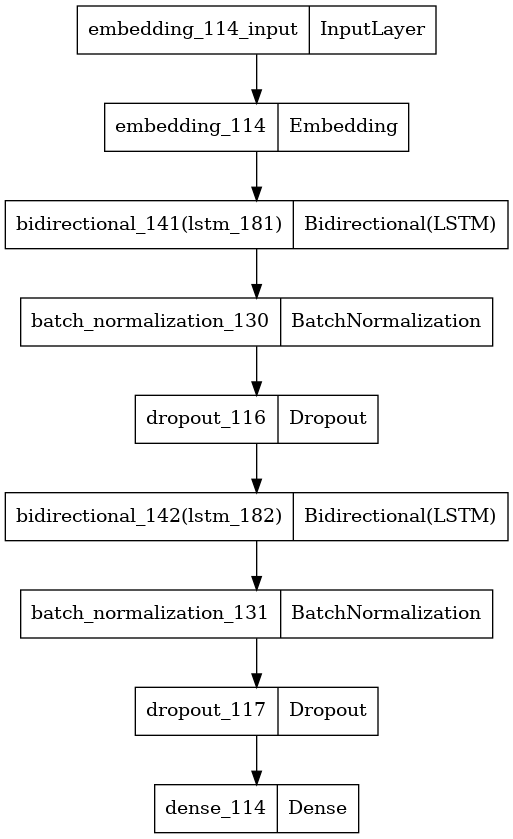

In [85]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png'
)

In [92]:
y_val_pred = model.predict(inputs_val_ids)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(labels_val_encoded, axis=1)

labels_val_names = [emotion_name[label] for label in y_val_true_classes]
pred_labels_names = [emotion_name[label] for label in y_val_pred_classes]

print(classification_report(labels_val_names, pred_labels_names))

79/79 [==============================] - 2s 21ms/step
               precision    recall  f1-score   support

aborrecimento       0.76      0.56      0.65        57
    admiração       0.87      0.71      0.78       129
      alegria       0.68      0.52      0.59       111
       alívio       0.83      0.83      0.83        59
         amor       0.75      0.59      0.66        79
    compaixão       0.85      0.59      0.70        49
     confusão       0.85      0.89      0.87       279
  curiosidade       0.84      0.75      0.79        61
     decepção       0.86      0.74      0.79        42
 desaprovação       0.70      0.72      0.71        32
       desejo       0.68      0.58      0.63       200
     diversão       0.64      0.81      0.72       203
   entusiasmo       0.91      0.76      0.83       120
     gratidão       0.00      0.00      0.00         5
       inveja       0.90      0.76      0.82        70
         luto       0.56      0.44      0.50        72
         m

In [93]:
report_e = classification_report(labels_val_names, pred_labels_names, output_dict=True)
df_report_e = pd.DataFrame(report_e).transpose()
df_report_e

,precision,recall,f1-score,support
aborrecimento,0.761905,0.561404,0.646465,57.000000
admiração,0.866667,0.705426,0.777778,129.000000
alegria,0.682353,0.522523,0.591837,111.000000
alívio,0.830508,0.830508,0.830508,59.000000
amor,0.746032,0.594937,0.661972,79.000000
compaixão,0.852941,0.591837,0.698795,49.000000
confusão,0.849315,0.888889,0.868651,279.000000
curiosidade,0.836364,0.754098,0.793103,61.000000
decepção,0.861111,0.738095,0.794872,42.000000
desaprovação,0.696970,0.718750,0.707692,32.000000


In [94]:
df_report_emb_emotions = df_report_e.drop(['accuracy', 'macro avg', 'weighted avg'])

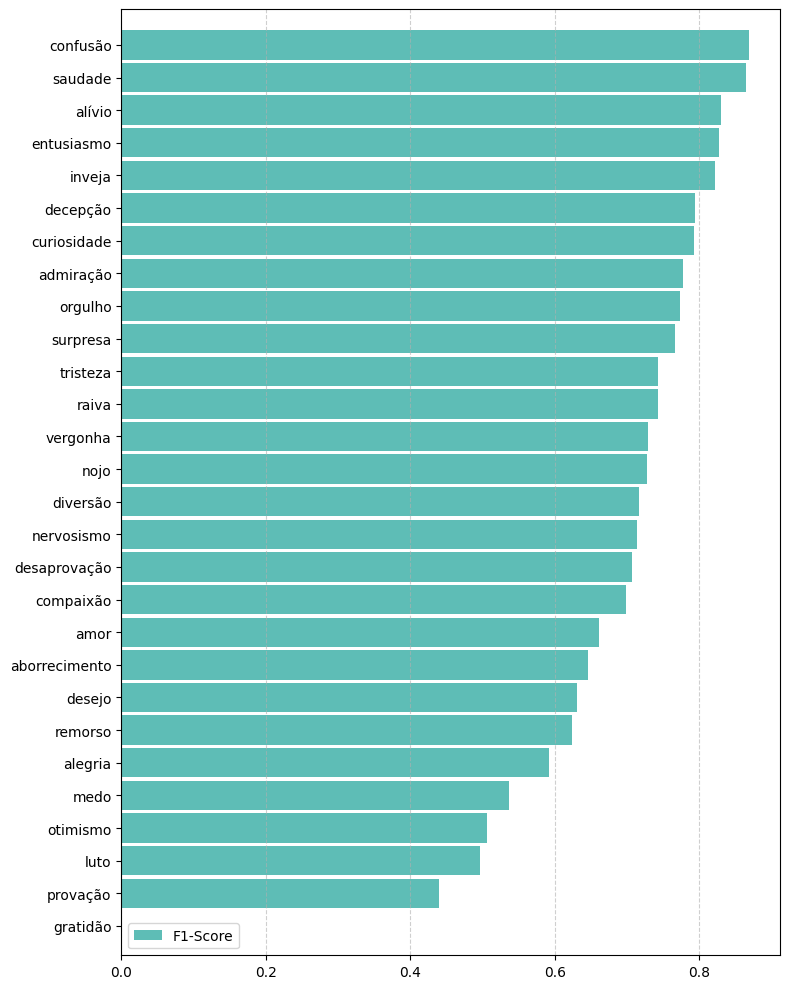

In [98]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

metric_to_compare = 'f1-score'


df_report_emb_emotions = df_report_emb_emotions.sort_values(by=metric_to_compare, ascending=True)


colors = sns.color_palette("husl", 2)

fig, ax = plt.subplots(figsize=(8, 10))

bar_height = 0.9
bar_positions_tf = np.arange(len(df_report_emb_emotions))
bar_positions_cv = bar_positions_tf + bar_height

ax.barh(bar_positions_cv, df_report_emb_emotions[metric_to_compare], height=bar_height, label='F1-Score', color=colors[1], alpha=0.8)

ax.set_yticks(bar_positions_tf + bar_height)
ax.set_yticklabels(df_report_emb_emotions.index)

ax.legend(loc='best')

ax.grid(axis='x', linestyle='--', alpha=0.6)

ax.set_ylim(0, len(df_report_emb_emotions)+1)
plt.tight_layout()
plt.show()



In [99]:
df_report_emb_emotions

,precision,recall,f1-score,support
gratidão,0.000000,0.000000,0.000000,5.0
provação,0.523810,0.379310,0.440000,29.0
luto,0.561404,0.444444,0.496124,72.0
otimismo,0.538462,0.477273,0.506024,44.0
medo,0.409091,0.782609,0.537313,115.0
alegria,0.682353,0.522523,0.591837,111.0
remorso,0.554217,0.713178,0.623729,129.0
desejo,0.684211,0.585000,0.630728,200.0
aborrecimento,0.761905,0.561404,0.646465,57.0
amor,0.746032,0.594937,0.661972,79.0
